In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv(override=True)

from pydantic import BaseModel, Field

import nest_asyncio
nest_asyncio.apply()
from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser
from llama_index.core.schema import TextNode, IndexNode, NodeRelationship, RelatedNodeInfo
from typing import List, Dict
import re
import plotreader
from plotreader.utils.document import ScientificPaperHandler
from plotreader.utils.base import BasicAnthropicLLM

In [3]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    # filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/s42003-021-01878-9.pdf",
    # document_id = "b562c2f2-b776-4829-b18c-6c6ebf4f788d",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [4]:
all_nodes = handler.load_docs()

In [7]:
all_nodes

[TextNode(id_='2489352a-7c62-4272-8a19-0746ceb0f845', embedding=None, metadata={'Header_1': 'Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics', 'experimental_variable_entities': ['channelrhodopsin', 'optogenetics'], 'fig_refs': []}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='c2155598-52f8-4e4f-9b94-62149747c0b0', node_type=None, metadata={}, hash=None)}, text='Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics\n\nClaire N. Bedbrook<sup>1</sup>, Kevin K. Yang<sup>2,†</sup>, J. Elliott Robinson<sup>1,†</sup>, Elisha D. Mackey<sup>1</sup>, Viviana Gradinaru<sup>1,*</sup>, Frances H. Arnold<sup>1,2,*<

In [5]:
fig_num = 3

filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value=f'Figure {fig_num}',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

query_tool = handler.query_engine_tool(top_k=10, metadata_filters=filters)

In [6]:
class Variable(BaseModel):
    name: str
    categorical: bool

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    # statistics: List[str]



In [7]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting data from figures in scientific papers.
    You will always primarily look to the image of the figure.
    You will look to text to obtain more detail if necessary.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
Complete the following task by visual inspection of the figure ONLY. Omit information if not available in the image.
For each plot in each panel of THE IMAGE of Fig. {fig_num}, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
By plot, we mean each set of axes or displays. Each panel can have multiple plots. See the json definition below for more.

Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [8]:
response = query_tool(prompt)

In [9]:
response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='6d1ee3b6-ef3e-45ae

In [10]:
figure_struct = output_parser.parse(response.content)

In [11]:
fig_description = f"{figure_struct.name}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name}"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 3
	Panel: b

		Plot: Microscope images
			independent_variables=[Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Neuron morphology', categorical=False)]
	Panel: c

		Plot: Photocurrent bar graphs
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Light intensity', categorical=True)] dependent_variables=[Variable(name='Photocurrent', categorical=False)]
	Panel: d

		Plot: Spike fidelity vs Light intensity
			independent_variables=[Variable(name='Light intensity', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Spike fidelity', categorical=False)]
	Panel: e

		Plot: Spike fidelity vs Frequency
			independent_variables=[Variable(name='Frequency', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Spike fidelity', categorical=False)]
	Panel: f

		Plot: Voltage traces
			independent_variables=[Variable(n

In [44]:
from typing import Union

In [45]:
panel = figure_struct.panels[2]
plot = panel.plots[0]
exp = plot.experiments[0]

class CategoricalVariable(BaseModel):
    name: str
    label_type: str = Field(
        ...,
        description="What type of visual signifier is used to label this class in the plot (e.g. color, markertype, etc.)"
    )
    values: dict[str, Union[str, list[float]]] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable. If the label is color, give the RGB value as a list of float."
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting categorical labels from plots in scientific papers.
    You will always primarily look to the image of the figure.
    If the information is not available in the image, you can look to the text.
    You will always dummy check your answer by counting the number of expected labels in the image.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
        In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
    Return your answer as structured data.
        """
        
    else:
        var_cls = NumericVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given an numeric independent variable and a plot containing datapoints corresponding to that variable.
    Your job is to give the set of values for that variable for the markers in the the specific plot (not the whole figure). 
    You will always dummy check your answer by counting the number of expected datapoints in the plot.

    YOUR CURRENT TASK:

In Figure {fig_num}{panel.name}, plot title/description: {plot.name}, what set are the values of {iv.name} plotted across all data in the panel?
    IMPORTANT: 
        WE WANT TO MATCH THE FIGURE. USE THE TEXT TO HELP, BUT IF THERE IS A DISCREPANCY, RESOLVE ASSUMING THE IMAGE IS CORRECT.
        COUNT THE NUMBER OF POINTS OR LINES IN THE IMAGE TO ENSURE THAT YOU RETURN THE CORRECT NUMBER OF VALUES.
        THAT IS, DO NOT REPORT THE LOCATIONS OF AXIS TICKE MARKS OR TICK MARK LABELS, REPORT THE VALUES OF THE POINTS ON THE PLOT!!!
    Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    # response = query_tool(prompt)
    # text = response.content

    response = query_tool(prompt)
    text = response.content

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Light intensity' categorical=False
name='ChR variant' categorical=True


In [46]:
ivs_with_values

[NumericVariable(name='Light intensity', values=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0], unit='mW mm^-2'),
 CategoricalVariable(name='ChR variant', label_type='color', values={'ChRger1': [255.0, 192.0, 203.0], 'ChRger2': [0.0, 255.0, 255.0], 'ChRger3': [0.0, 255.0, 0.0], 'CoChR': [128.0, 128.0, 128.0], 'ChR2': [0.0, 0.0, 0.0]})]

In [14]:
response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='6d1ee3b6-ef3e-45ae

In [15]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [16]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given a numeric dedependent variable and a plot containing data points which have values for that variable.
    Your job is to give values for the markers in the plot as a function of the provided independent variables.
    We want to match the data points in the plot EXACTLY - not just the shapes or trends.
    You will always dummy check your answer by counting the number of expected datapoints, lines, etc in the plot.
    When there is a discrepency between text and graphic, align your answer to the graphic.

In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?
Get the value for each condition. To help, here is our current belief on the independent variables and their values for this plot:
{ind_vars}

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response = query_tool(prompt)
panel_df = output_parser.parse(data_response.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [17]:
data_response.raw_output.source_nodes

[NodeWithScore(node=ImageNode(id_='ddbd3ffb-d1c1-4a05-9c3a-180685f3910b', embedding=None, metadata={'page_number': 24, 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='79966a73-edea-46f3-b47f-81295e5616cb', node_type=None, metadata={}, hash=None)}, text='The graphic compares the performance of ChRger variants with commonly used ChR2 (H134R) and CoChR in cultured neurons and acute brain slices. It includes data on photocurrent strength, spike fidelity, and light intensity response.\n\na) ChRs were cloned into an AAV vector with either the hSyn or CamKIIa promoter and packaged into rAAV-PHP.eB for expression in culture and in vivo.\n\nb) Cultured neurons expressing ChRgers and ChR2 (H134R) under the hSyn promoter. Images show neurons with ChR2, ChRger1, ChRger2, and ChRger3. Scale bars are 10 μm.\n\nc) Peak and steady-state photocurrent with low-intensity (8x10^-3 mW mm^-2) a

In [18]:


# def get_color(color_name):
#     try:
#         return mcolors.to_rgba(color_name)
#     except ValueError:
#         # If the color name is not recognized, you can provide a fallback
#         return mcolors.to_rgba('gray')
    



In [19]:
import seaborn as sns

[]

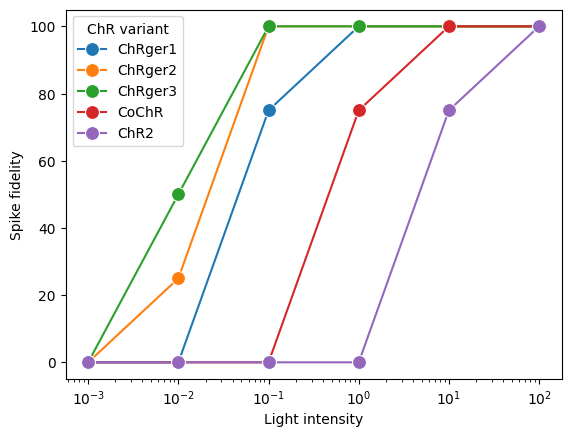

In [47]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

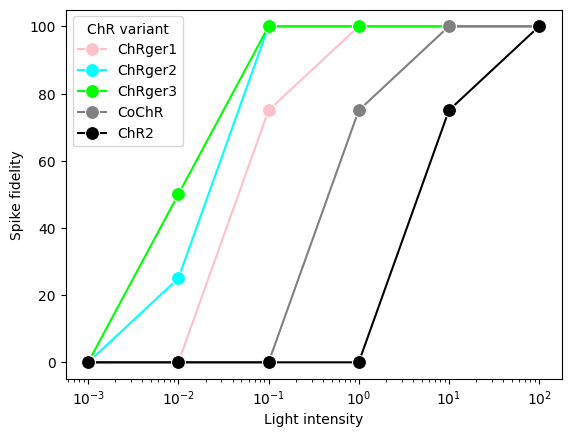

In [51]:
chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items()]
palette = [np.array(v)/255. for k,v in chr_variant_iv.values.items()]

axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)
axes.set_xscale('log')

In [327]:
from PIL import Image

# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img = Image.open('plot.png')

In [328]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO

from plotreader.utils.base import BasicAnthropicLLM

claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")

for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response = claude_mm.message(prompt, images = [source_figure, generated_img])

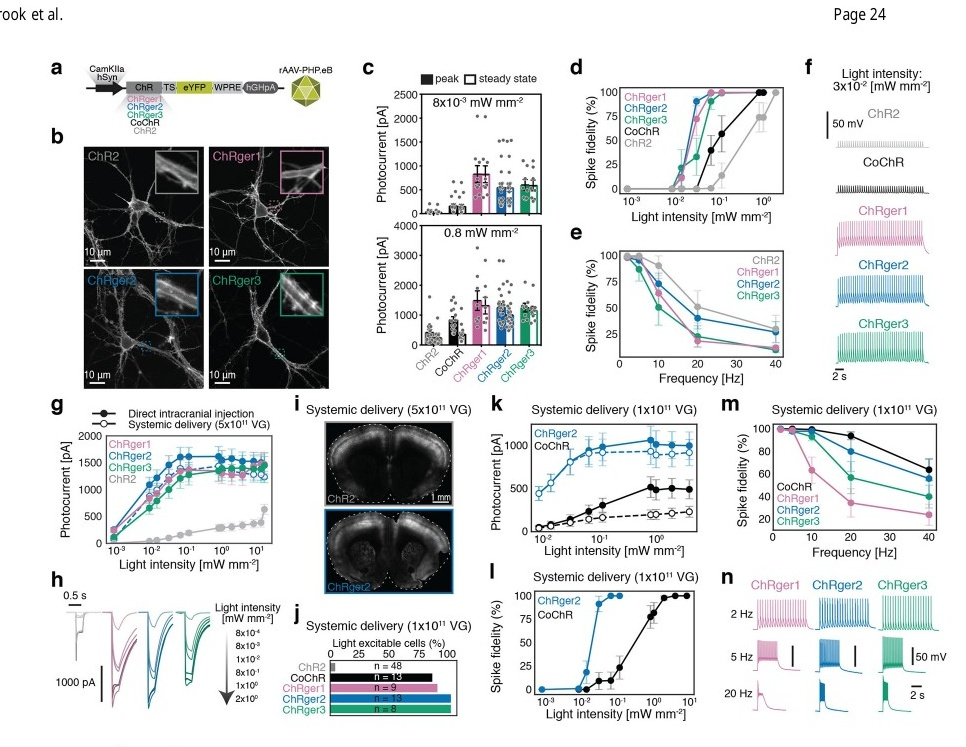

In [329]:
source_figure

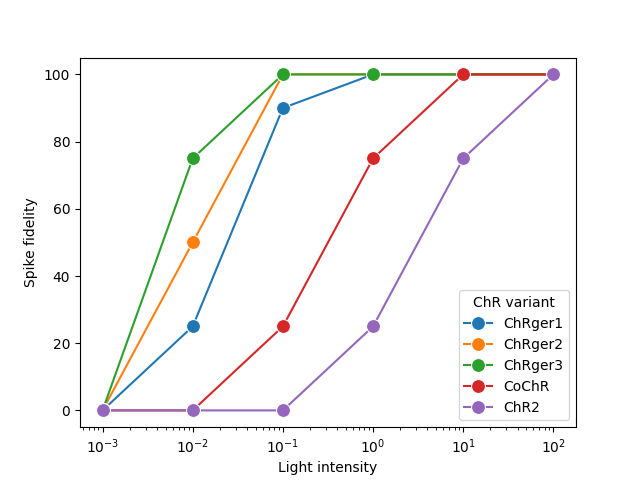

In [330]:
generated_img

In [331]:
print(response.content[0].text)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1, ChRger2, and ChRger3: In the source figure, these curves appear to be smoother and more sigmoidal, especially between 0.01 and 0.1 mW/mm². In the re-plotted data, these curves are more angular and abrupt. For example, ChRger3 in the re-plot jumps from 75% to 100% spike fidelity between 0.01 and 0.1 mW/mm², while in the original, it appears to have a more gradual increase.

2. CoChR performance at low light intensities: In the source figure, CoChR shows some activity (around 25% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm² and only starts showing activity (25%) at 0.1 mW/mm².

3. ChR2 performance at higher light intensities: In the source figure, ChR2 appears to reach close to 100% spike fidelity at 100 mW/mm². In the re-plotted data, ChR2 reaches exactly 100% at this intensity

In [332]:
feedback = response.content[0].text

In [351]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

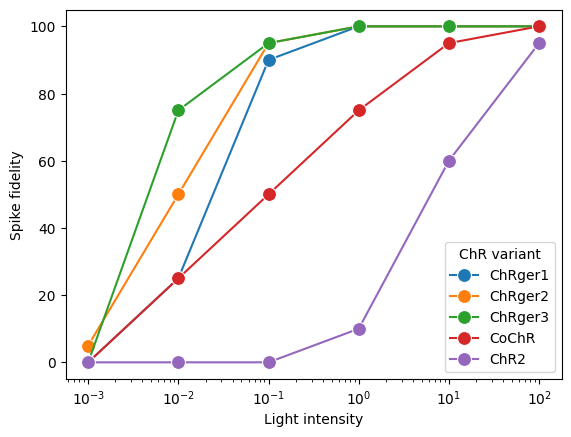

In [352]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [345]:
# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img_rev = Image.open('plot.png')

In [346]:


claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")


prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response_2 = claude_mm.message(prompt, images = [source_figure, generated_img_rev])

In [347]:
feedback_2 = response_2.content[0].text
print(feedback_2)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1: In the source figure, the ChRger1 curve (pink) shows a more gradual increase in spike fidelity between 0.01 and 0.1 mW/mm². However, in the re-plotted data, there's a sharp jump from 25% at 0.01 mW/mm² to 95% at 0.1 mW/mm². This difference significantly alters the shape of the curve for ChRger1 in the low light intensity range.

2. CoChR performance at low intensities: In the source figure, the CoChR curve (black) shows some activity (around 20-30% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm². This difference affects the interpretation of CoChR's sensitivity at low light intensities.

3. ChR2 curve shift: In the source figure, the ChR2 curve (gray) begins to rise noticeably around 1 mW/mm² and reaches about 50% spike fidelity at 10 mW/mm². In the re-plotted data, the ChR2 curv

In [364]:
panel_df

Light intensity ChR variant Spike fidelity
0             0.001     ChRger1              0
1             0.010     ChRger1              0
2             0.100     ChRger1             75
3             1.000     ChRger1            100
4            10.000     ChRger1            100
5           100.000     ChRger1            100
6             0.001     ChRger2              0
7             0.010     ChRger2             25
8             0.100     ChRger2            100
9             1.000     ChRger2            100
10           10.000     ChRger2            100
11          100.000     ChRger2            100
12            0.001     ChRger3              0
13            0.010     ChRger3             50
14            0.100     ChRger3            100
15            1.000     ChRger3            100
16           10.000     ChRger3            100
17          100.000     ChRger3            100
18            0.001       CoChR              0
19            0.010       CoChR              0
20            0.100       CoChR              0
21            1.000       CoChR             50
22           10.000       CoChR            100
23          100.000       CoChR            100
24            0.001        ChR2              0
25            0.010        ChR2              0
26            0.100        ChR2              0
27            1.000        ChR2              0
28           10.000        ChR2             75
29          100.000        ChR2            100

In [348]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback_2,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

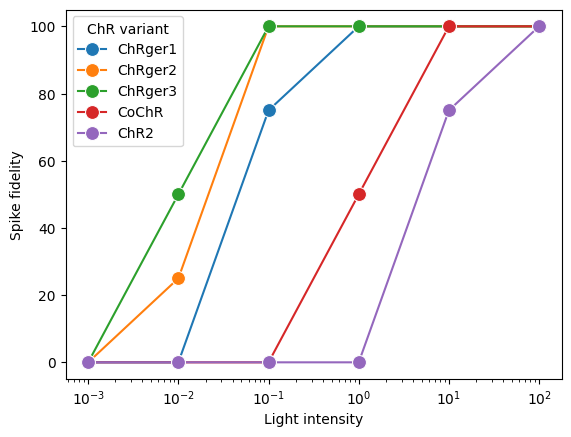

In [28]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [24]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO
from PIL import Image


In [25]:
for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

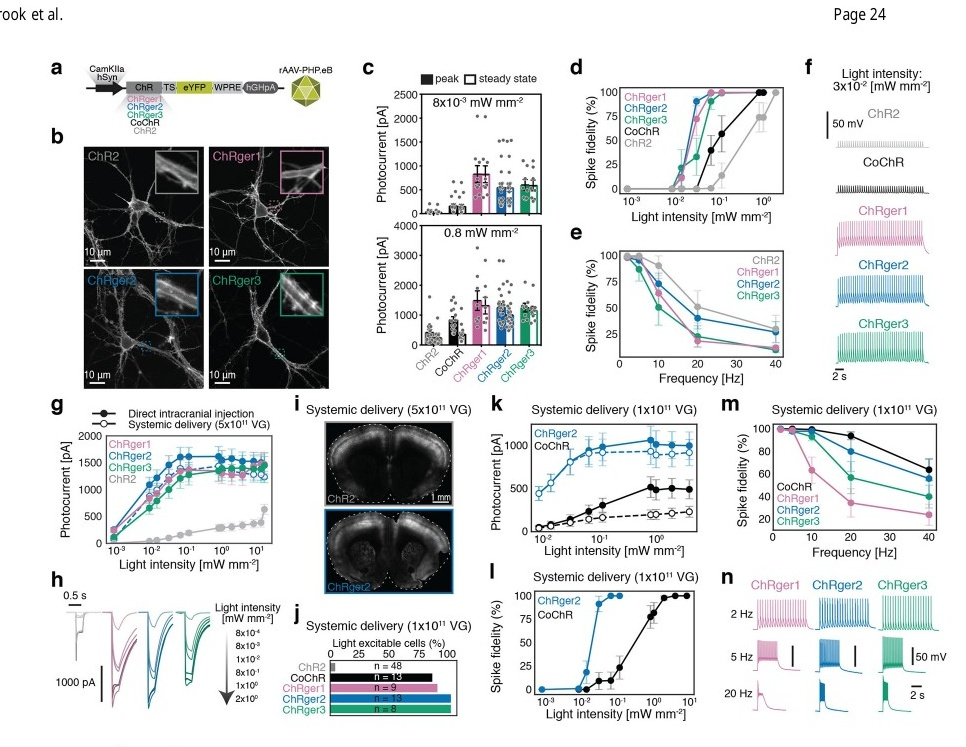

In [26]:
source_figure

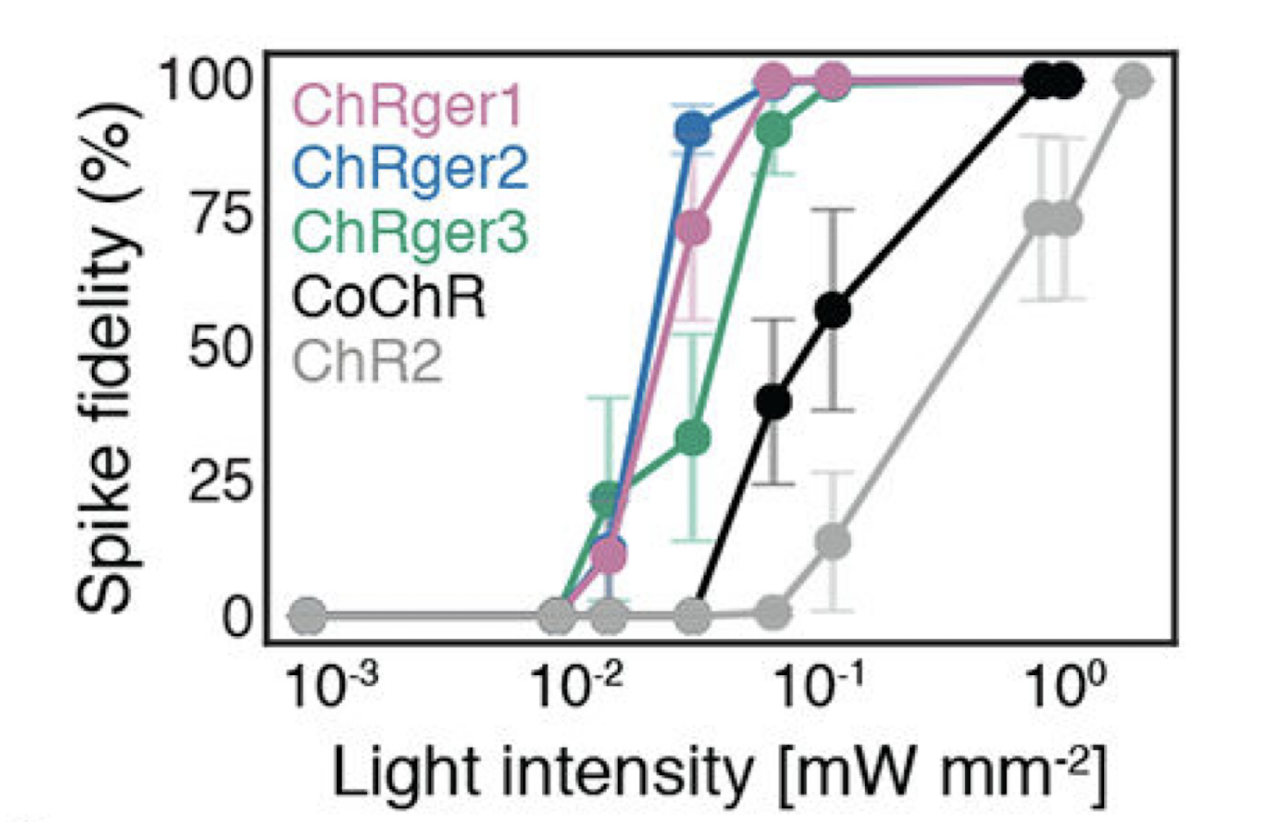

In [27]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
source_image = Image.open(source_panel)
source_image

In [54]:
import numpy as np

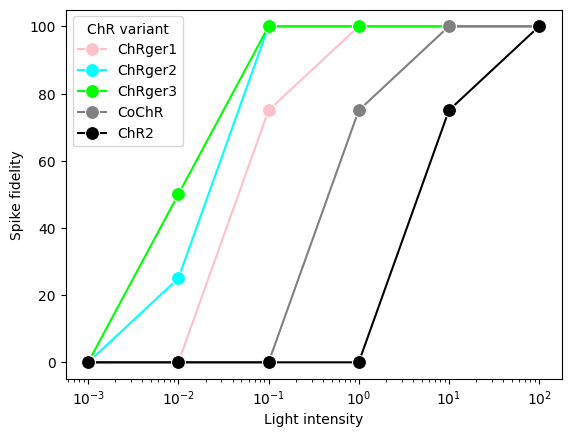

In [55]:
chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items()]
palette = [np.array(v)/255. for k,v in chr_variant_iv.values.items()]

axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette
)
axes.set_xscale('log')

After comparing the original figure and the recreated plot using the extracted data, here are the three largest quantitative differences:

1. ChRger3 curve shift: In the original figure, ChRger3 (green line) shows a more gradual increase in spike fidelity, with a value around 25% at 10^-2 mW mm^-2 and reaching 100% at about 10^-1 mW mm^-2. In the recreated plot, ChRger3 shows a much steeper increase, with 50% spike fidelity at 10^-2 mW mm^-2 and already reaching 100% at 10^-1 mW mm^-2. This represents a significant shift in the curve's shape and position.

2. CoChR curve shape: The original figure shows CoChR (black line) with a more gradual increase in spike fidelity, starting to rise around 10^-2 mW mm^-2 and reaching 100% at about 10^-1 mW mm^-2. In the recreated plot, CoChR has a much steeper increase, staying at 0% until 10^0 mW mm^-2, then jumping to 75% at this point, and reaching 100% at 10^1 mW mm^-2. This represents a significant change in the curve's shape and threshold.

3.

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot using the extracted data, here are the three largest quantitative differences:

1. Range of Light Intensity: The source figure shows light intensity ranging from 10^-3 to 10^0 mW mm^-2, while the recreated plot extends to 10^2 mW mm^-2. This is a significant difference in the x-axis scale, affecting the overall appearance of the data.

2. ChR2 Curve Shape: In the source figure, the ChR2 curve (gray) shows a more gradual increase, reaching about 75% spike fidelity at 10^0 mW mm^-2. In the recreated plot, the ChR2 curve rises more steeply, reaching 100% spike fidelity at 10^2 mW mm^-2. This difference affects the overall shape and position of the ChR2 curve.

3. CoChR Data Points: The source figure shows the CoChR curve (black) reaching about 40% spike fidelity at 10^-1 mW mm^-2, while in the recreated plot, the CoChR curve reaches 50% spike fidelity at 10^-1 mW mm^-2. This difference affects the position and shape of the CoChR cur

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the re-plotted data, here are the three largest quantitative differences:

1. ChR2 curve shape: In the source figure, ChR2 (gray line) shows a gradual increase in spike fidelity from 0% to about 75% between light intensities of 10^-1 and 10^0 mW mm^-2. In the re-plotted data, ChR2 jumps abruptly from 0% at 10^-1 to 75% at 10^0 mW mm^-2, missing the gradual increase.

2. CoChR curve shape: The source figure shows CoChR (black line) with a more gradual increase in spike fidelity, starting around 10^-2 mW mm^-2 and reaching 100% at 10^-1 mW mm^-2. The re-plotted data shows a steeper increase, with 0% at 10^-2, 40% at 10^-1, and 100% at 10^0 mW mm^-2, missing the intermediate points.

3. ChRger2 spike fidelity at 10^-2 mW mm^-2: In the source figure, ChRger2 (blue line) shows a spike fidelity of about 90% at 10^-2 mW mm^-2. However, in the re-plotted data, ChRger2 has a spike fidelity of only 50% at this light intensity, which is a significant underest

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the re-plotted data, here are the three largest quantitative differences I've identified:

1. ChRger3 curve shape: In the original figure, ChRger3 (green line) shows a more gradual increase in spike fidelity between 0.01 and 0.1 mW mm^-2, with a value around 35% at 0.01 mW mm^-2. In the re-plotted data, ChRger3 jumps from 60% at 0.01 mW mm^-2 to 100% at 0.1 mW mm^-2, showing a much steeper increase.

2. CoChR curve shape: The original figure shows CoChR (black line) with a more gradual increase, with values around 40% at 0.01 mW mm^-2 and 60% at 0.1 mW mm^-2. In the re-plotted data, CoChR jumps from 25% at 0.01 mW mm^-2 to 100% at 0.1 mW mm^-2, which is a much steeper increase than in the original.

3. ChR2 maximum spike fidelity: In the original figure, ChR2 (gray line) reaches a maximum spike fidelity of about 100% at 1 mW mm^-2. However, in the re-plotted data, ChR2 only reaches 75% spike fidelity at the highest light intensity of 1 mW mm^-2.


/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot using the extracted data, here are the three largest quantitative differences:

1. Curve shape for ChRger3: In the source figure, ChRger3 (green line) shows a sigmoidal curve with a steep increase between 0.01 and 0.1 mW mm^-2. In the recreated plot, ChRger3 appears more linear, with a spike fidelity of 35% at 0.01 mW mm^-2 and 80% at 0.1 mW mm^-2. This difference affects the overall shape of the ChRger3 curve.

2. CoChR values at lower intensities: In the source figure, CoChR (black line) shows no activity until about 0.03 mW mm^-2, then rises steeply. In the recreated plot, CoChR shows 40% spike fidelity at 0.01 mW mm^-2 and 60% at 0.1 mW mm^-2, which is a significant deviation from the original curve shape and values.

3. ChRger1 and ChRger2 distinction: In the source figure, ChRger1 (pink) and ChRger2 (blue) have distinct curves, with ChRger2 showing higher spike fidelity at lower light intensities. In the recreated plot, the

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, here are the three largest quantitative differences:

1. ChRger2 sensitivity at low light intensity: In the re-plotted data, ChRger2 shows a spike fidelity of 25% at 0.001 mW mm^-2, while in the source figure, it appears to be close to 0% at this light intensity. This is a significant difference in the low-intensity response of ChRger2.

2. ChRger3 response curve shape: The re-plotted data shows a more linear increase in spike fidelity for ChRger3, with values of 0%, 50%, 95%, and 100% as light intensity increases. In contrast, the source figure displays a more sigmoidal curve for ChRger3, with a steeper increase between 0.01 and 0.1 mW mm^-2.

3. CoChR response at medium light intensity: In the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW mm^-2 and jumps to 75% at 0.1 mW mm^-2. However, in the source figure, CoChR appears to have a more gradual increase, with a spike fidelity around 40-50% at 0.1 mW mm^-2.

These

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the re-plotted data, here are the three largest quantitative differences:

1. ChR2 curve: In the original figure, ChR2 shows a spike fidelity of about 75% at 1 mW mm^-2 light intensity. However, in the re-plotted data, ChR2 reaches 100% spike fidelity at this intensity. This is a difference of about 25 percentage points for the highest intensity data point.

2. CoChR curve: The original figure shows CoChR reaching about 40% spike fidelity at 0.1 mW mm^-2, while the re-plotted data shows 50% at this intensity. This is a difference of approximately 10 percentage points.

3. ChRger2 curve: In the original figure, ChRger2 shows about 80% spike fidelity at 0.01 mW mm^-2, whereas the re-plotted data shows 90% at this intensity. This represents a difference of about 10 percentage points.

These differences affect the overall shape and position of the curves, particularly for ChR2 and CoChR, which could lead to different interpretations of the relative p

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, here are the three largest quantitative differences:

1. CoChR curve shape: In the source figure, CoChR (black line) shows a gradual increase in spike fidelity from 0% at 10^-2 mW mm^-2 to about 60% at 10^-1 mW mm^-2. However, in the re-plotted data, CoChR jumps from 0% at 10^-2 mW mm^-2 directly to 40% at 10^-1 mW mm^-2, and then to 100% at 10^0 mW mm^-2. This represents a significant difference in the curve's shape and intermediate values.

2. ChR2 spike fidelity at high intensity: In the source figure, ChR2 (gray line) reaches about 75% spike fidelity at 10^0 mW mm^-2. The re-plotted data matches this value exactly, but the curve leading up to this point is different. The re-plotted data shows 0% spike fidelity up to 10^-1 mW mm^-2, then jumps directly to 75% at 10^0 mW mm^-2, while the source figure shows a more gradual increase starting from about 10^-1 mW mm^-2.

3. ChRger3 spike fidelity at medium intensity: In the sour

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the re-plotted data, here are the three largest quantitative differences:

1. ChR2 curve shift: In the original figure, the ChR2 curve (gray) reaches about 75% spike fidelity at 1 mW mm^-2 light intensity. In the re-plotted data, it reaches 100% at this intensity, which is a significant 25 percentage point difference.

2. CoChR curve shape: The original figure shows the CoChR curve (black) with a more gradual increase, reaching about 40% spike fidelity at 0.1 mW mm^-2. In the re-plotted data, there's a sharp jump from 0% to 60% between 0.01 and 0.1 mW mm^-2, which is a notable difference in curve shape and specific values.

3. ChRger3 mid-range values: In the original figure, ChRger3 (green) shows about 25% spike fidelity at 0.01 mW mm^-2 and around 90% at 0.1 mW mm^-2. The re-plotted data shows 35% and 95% at these intensities respectively, which represents a consistent upward shift of about 5-10 percentage points in this range.

These differenc

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the recreated plot with the source figure, here are the three largest quantitative differences:

1. Lack of error bars: The recreated plot does not include any error bars, while the source figure shows clear error bars for most data points, particularly noticeable for ChRger3, CoChR, and ChR2 at various light intensities. This absence of error representation is a significant difference affecting the interpretation of data variability.

2. CoChR curve shape: In the recreated plot, the CoChR curve shows a linear increase from 0% at 0.01 mW mm^-2 to 40% at 0.1 mW mm^-2. However, in the source figure, this increase is more sigmoidal, with the curve starting to rise noticeably only after 0.01 mW mm^-2 and reaching about 40% at 0.1 mW mm^-2. This difference in curve shape affects the interpretation of CoChR's light sensitivity.

3. ChR2 values at higher intensities: In the recreated plot, ChR2 shows 0% spike fidelity at 0.1 mW mm^-2 and 75% at 1 mW mm^-2. However, in the sour

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the re-plotted data, here are the three largest quantitative differences:

1. Curve shape for ChRger1 and ChRger2: In the original figure, ChRger1 and ChRger2 show a steeper, more sigmoidal curve between 0.01 and 0.1 mW mm^-2. The re-plotted data shows a more gradual, linear increase for these variants. Specifically, at 0.01 mW mm^-2, the original figure shows spike fidelity around 20-30% for both, while the re-plotted data shows 75% for ChRger1 and 80% for ChRger2.

2. CoChR values at lower light intensities: In the original figure, CoChR shows 0% spike fidelity up to about 0.03 mW mm^-2, then rises sharply. In the re-plotted data, CoChR already shows 40% spike fidelity at 0.1 mW mm^-2, indicating a more gradual increase starting at lower light intensities.

3. ChR2 curve shape: The original figure shows ChR2 with a more sigmoidal curve, starting to rise around 0.1 mW mm^-2 and reaching near 100% by 1 mW mm^-2. The re-plotted data shows a more l

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, I can identify the following three largest quantitative differences:

1. CoChR curve shift: In the source figure, the CoChR curve (black line) shows no response at 10^-2 mW mm^-2 and begins to rise sharply between 10^-2 and 10^-1 mW mm^-2. In the re-plotted data, the CoChR curve shows no response at 10^-2 mW mm^-2 but jumps directly to 60% spike fidelity at 10^-1 mW mm^-2. This represents a significant difference in the shape and position of the CoChR curve.

2. ChR2 curve shift: The ChR2 curve (gray in the source, black in the re-plot) shows a notable difference. In the source figure, ChR2 begins to show response around 10^-1 mW mm^-2 and reaches about 75% spike fidelity at 10^0 mW mm^-2. In the re-plotted data, ChR2 shows only 5% spike fidelity at 10^-1 mW mm^-2 and reaches 95% at 10^0 mW mm^-2. This represents a rightward shift of the ChR2 curve in the re-plotted data.

3. ChRger variants' response at low intensity: In the 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the re-plotted data with the source figure, here are the three largest quantitative differences:

1. CoChR curve shape: In the source figure, CoChR (black line) shows a gradual increase in spike fidelity from 10^-2 to 10^0 light intensity, reaching about 60% at 10^-1 and 100% at 10^0. In the re-plotted data, CoChR shows a much steeper increase, with 0% at 10^-2, 40% at 10^-1, and 98% at 10^0. This difference affects the overall shape and position of the CoChR curve.

2. ChR2 performance at high intensity: In the source figure, ChR2 (gray line) reaches about 75% spike fidelity at 10^0 light intensity. The re-plotted data matches this value exactly. However, the source figure shows ChR2 reaching nearly 100% at a slightly higher intensity (just above 10^0), while the re-plotted data doesn't show this final increase, stopping at 75%.

3. ChRger variants at low intensities: In the source figure, ChRger1, ChRger2, and ChRger3 (pink, blue, and green lines) show some variation 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the re-plotted data, here are the three largest quantitative differences:

1. Data point density: The original figure has more data points for each ChR variant, especially in the 0.01 to 0.1 light intensity range. The re-plotted data only has 4 points per variant (5 for ChR2), resulting in less smooth curves and missing intermediate values.

2. ChR2 curve shape: In the original figure, the ChR2 curve shows a gradual increase starting from around 0.1 light intensity. In the re-plotted data, ChR2 remains at 0% spike fidelity until 1.0 light intensity, then jumps to 75%. This misses the gradual increase seen in the original.

3. CoChR curve shape: The original figure shows CoChR having a more gradual increase in spike fidelity between 0.01 and 0.1 light intensity. The re-plotted data shows a sharp jump from 0% at 0.01 to 60% at 0.1, missing the intermediate values that give the original curve its shape.

These differences affect the overall interpre

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the re-plotted data, I can identify three major quantitative differences:

1. ChR2 curve shift: In the original figure, the ChR2 curve (gray) is shifted further to the right compared to the re-plotted data. For example, in the original, ChR2 shows 0% spike fidelity at 0.1 mW mm^-2, while in the re-plot it shows 10% at this intensity. The entire curve for ChR2 is shifted about 0.5-1 log unit to the left in the re-plotted data.

2. CoChR curve shape: The CoChR curve (black) in the original figure has a more gradual slope, especially between 0.01 and 0.1 mW mm^-2. In the re-plotted data, this curve shows a steeper increase, jumping from 0% at 0.01 mW mm^-2 to 75% at 0.1 mW mm^-2. The original figure shows a more gradual increase over this range.

3. ChRger1 and ChRger2 separation: In the original figure, there's a clear separation between the ChRger1 (pink) and ChRger2 (blue) curves, especially in the 0.003 to 0.03 mW mm^-2 range. In the re-plotted 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the re-plotted data, here are the three largest quantitative differences:

1. ChR2 data points: In the original figure, ChR2 has additional data points at higher light intensities (3 mW/mm² and 10 mW/mm²) that are not present in the re-plotted data. This extends the ChR2 curve further to the right in the original figure, reaching 100% spike fidelity at 10 mW/mm².

2. CoChR curve shape: The CoChR curve in the re-plotted data shows a more gradual increase in spike fidelity compared to the original figure. In the original, CoChR reaches about 75% spike fidelity at 0.1 mW/mm², while in the re-plotted data, it only reaches 60% at this light intensity.

3. ChRger1 initial rise: In the original figure, ChRger1 shows a steeper initial rise, reaching about 40% spike fidelity at 0.01 mW/mm². In the re-plotted data, ChRger1 only reaches 20% spike fidelity at 0.003 mW/mm² and then jumps to 70% at 0.01 mW/mm², creating a less smooth curve compared to the orig

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the re-plotted data, here are the three largest quantitative differences:

1. Range of Light Intensity: The original figure shows light intensity ranging from 10^-3 to 10^0 mW mm^-2, while the re-plotted data extends to 10^1 mW mm^-2. This additional datapoint at 10 mW mm^-2 for ChR2 is not present in the original figure.

2. ChR2 curve shape: In the original figure, the ChR2 curve shows a more gradual increase in spike fidelity, with multiple intermediate points between 0% and 100%. The re-plotted data shows a steeper increase with fewer datapoints, particularly missing the intermediate points around 25% and 75% spike fidelity.

3. CoChR curve shape: The original figure shows the CoChR curve reaching 100% spike fidelity at a lower light intensity (around 10^-1 mW mm^-2) compared to the re-plotted data, where it reaches 100% at 1 mW mm^-2. This results in a different curve shape and position for CoChR between the two plots.

These differences aff

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the re-plotted data, I can identify three major quantitative differences:

1. ChR2 curve shape: In the original figure, the ChR2 curve (gray) shows a more gradual increase, reaching about 75% spike fidelity at 1 mW mm^-2. In the re-plotted data, the ChR2 curve shows a steeper increase, reaching 75% at 1 mW mm^-2 but with a more abrupt rise from 25% at 0.3 mW mm^-2.

2. CoChR curve shape: The original figure shows the CoChR curve (black) rising more gradually, reaching about 60% spike fidelity at 0.1 mW mm^-2. In the re-plotted data, the CoChR curve rises more steeply, reaching 100% spike fidelity at 0.1 mW mm^-2.

3. ChRger3 mid-range values: In the original figure, the ChRger3 curve (green) shows a spike fidelity of about 35% at 0.03 mW mm^-2. In the re-plotted data, the ChRger3 curve shows a much higher spike fidelity of 75% at the same light intensity.

These differences affect the overall shape and relative positions of the curves, potentiall

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the source figure and the recreated plot using the extracted data, here are the three largest quantitative differences:

1. CoChR curve shape: In the source figure, the CoChR curve (black) shows a more gradual increase, reaching about 40% spike fidelity at 0.1 mW mm^-2 and 60% at 0.3 mW mm^-2. In the recreated plot, the CoChR curve rises more steeply, reaching 60% at 0.1 mW mm^-2 and then jumping directly to 100% at 1 mW mm^-2. This difference affects multiple data points along the CoChR curve.

2. ChR2 maximum spike fidelity: In the source figure, the ChR2 curve (gray) reaches approximately 100% spike fidelity at 1 mW mm^-2. However, in the recreated plot, the maximum spike fidelity for ChR2 is only 75% at 1 mW mm^-2. This is a significant difference of about 25 percentage points for the final data point of the ChR2 curve.

3. ChRger3 curve shape: The ChRger3 curve (green) in the source figure shows a more sigmoidal shape, with a gentler increase at lower light intensi

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


After comparing the original figure and the re-plotted data, here are the three largest quantitative differences:

1. Curve shape for ChRger1 and ChRger2: In the original figure, the curves for ChRger1 and ChRger2 have a steeper rise between 0.01 and 0.03 mW mm^-2, reaching nearly 100% spike fidelity at 0.03 mW mm^-2. In the re-plotted data, this rise is more gradual, with ChRger1 and ChRger2 reaching only 95% and 85% spike fidelity respectively at 0.03 mW mm^-2.

2. CoChR curve position: In the original figure, the CoChR curve is shifted more to the right, with spike fidelity remaining close to 0% until about 0.03 mW mm^-2. In the re-plotted data, the CoChR curve starts rising earlier, showing 5% spike fidelity at 0.01 mW mm^-2 and 20% at 0.03 mW mm^-2.

3. ChR2 curve shape: The original figure shows the ChR2 curve remaining at 0% spike fidelity until about 0.1 mW mm^-2, then rising sharply to reach 100% at 1 mW mm^-2. In the re-plotted data, the ChR2 curve starts rising slightly earl

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)
/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_73765/1470453997.py:98: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots()


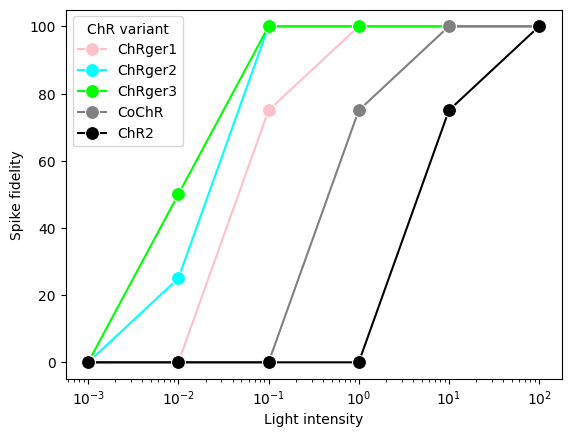

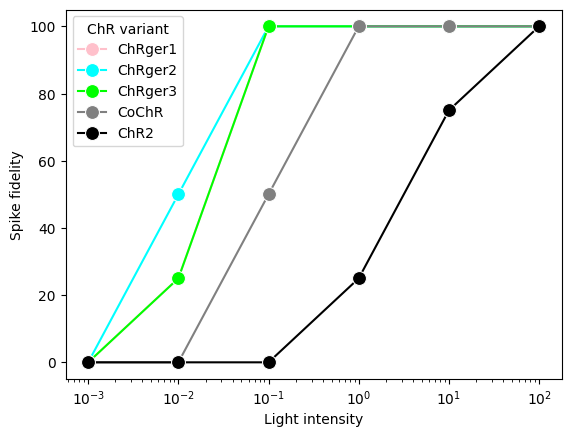

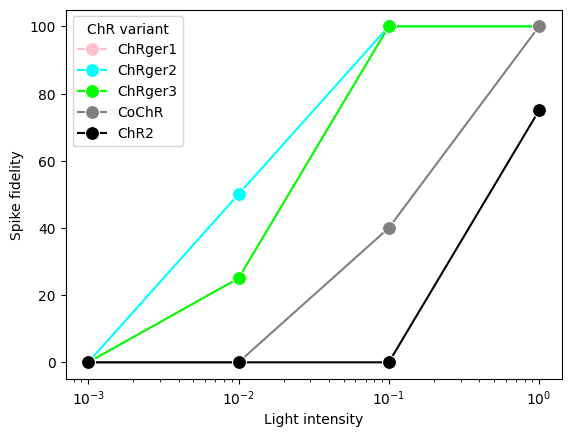

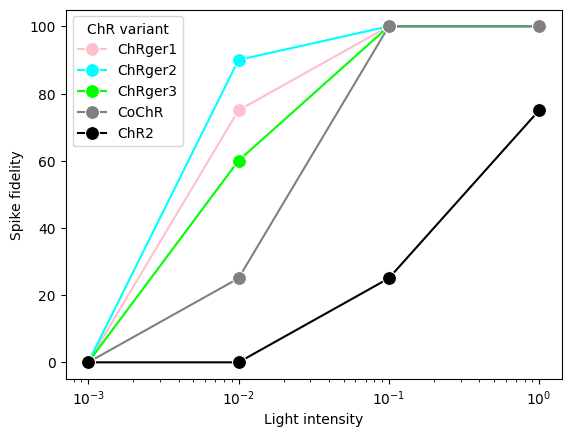

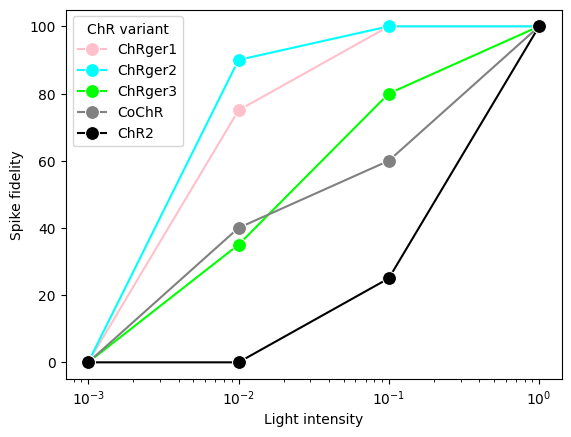

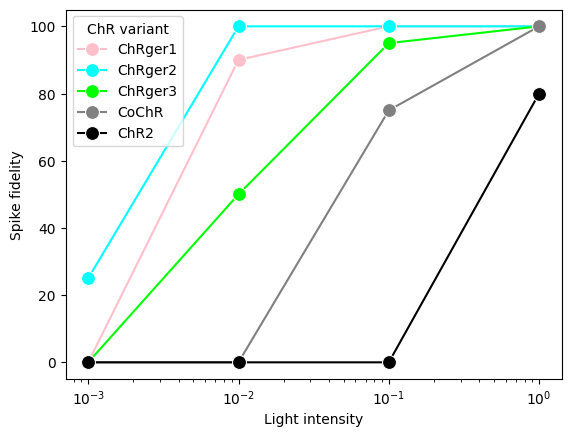

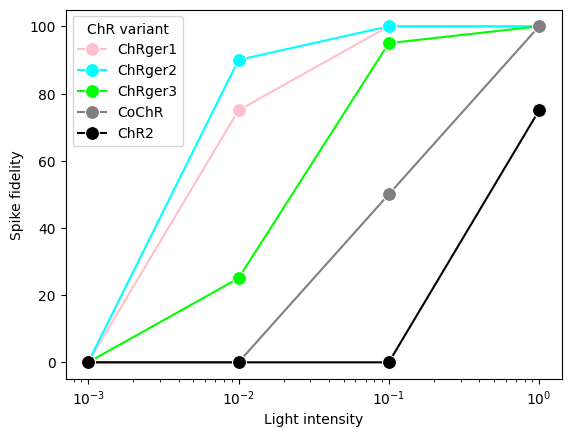

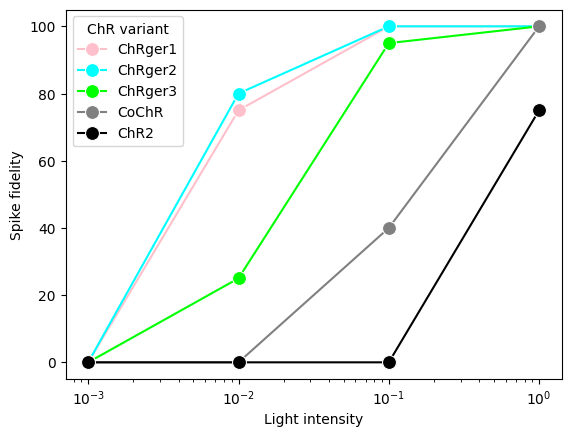

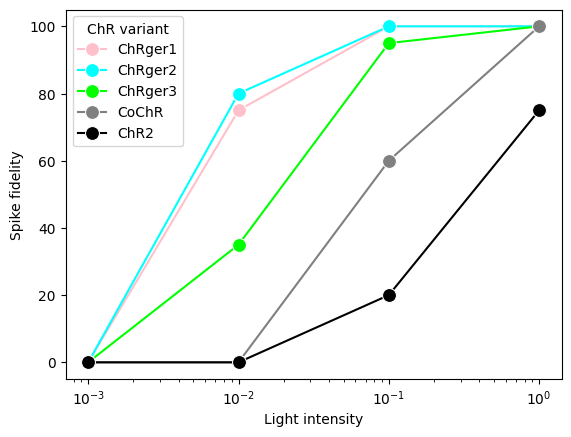

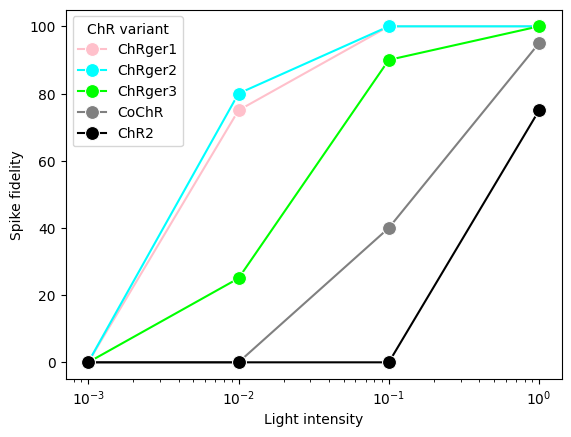

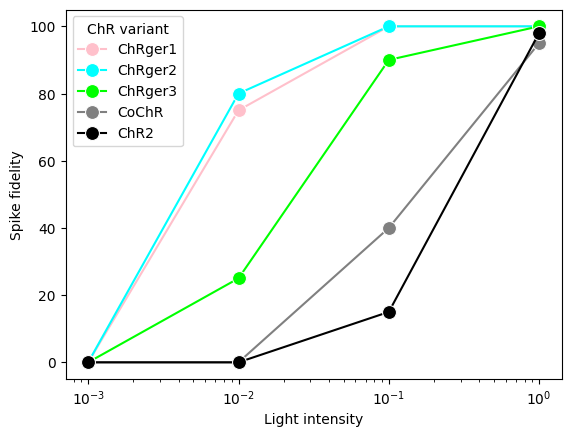

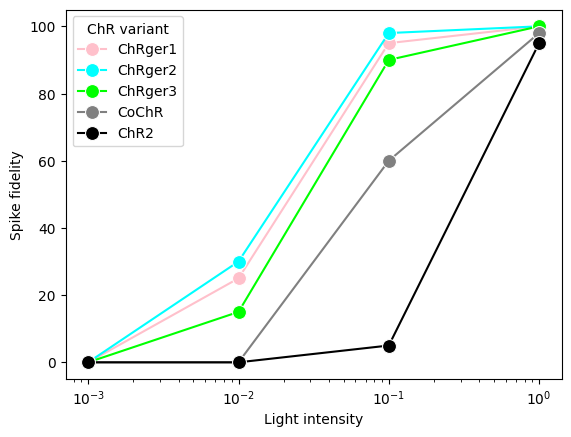

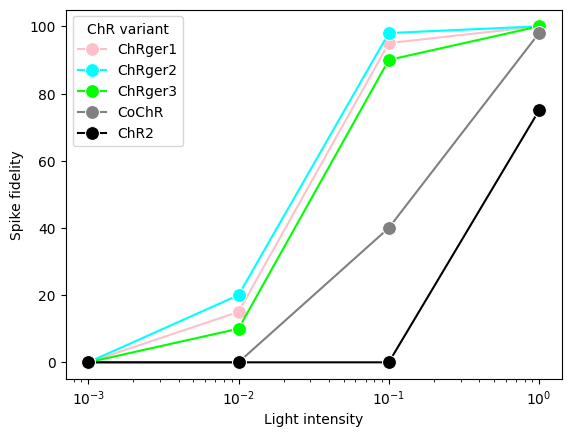

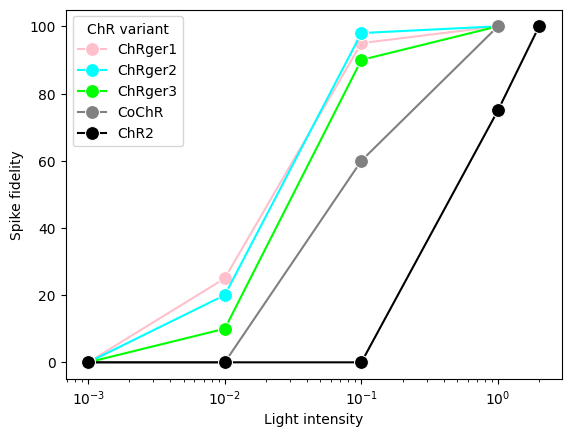

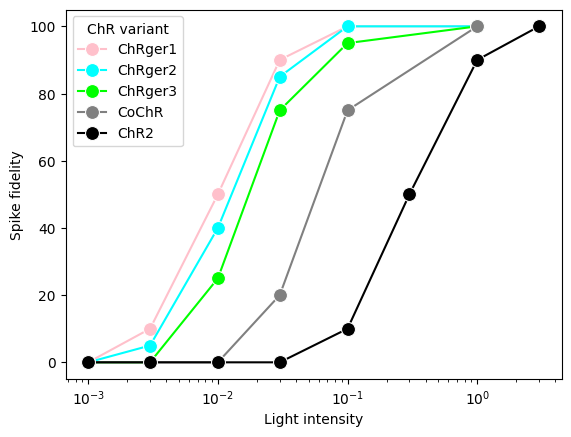

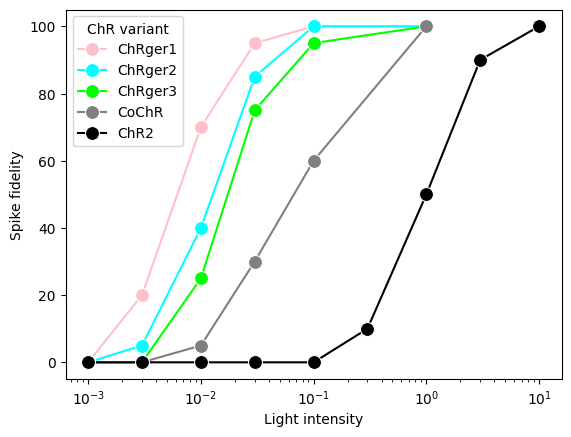

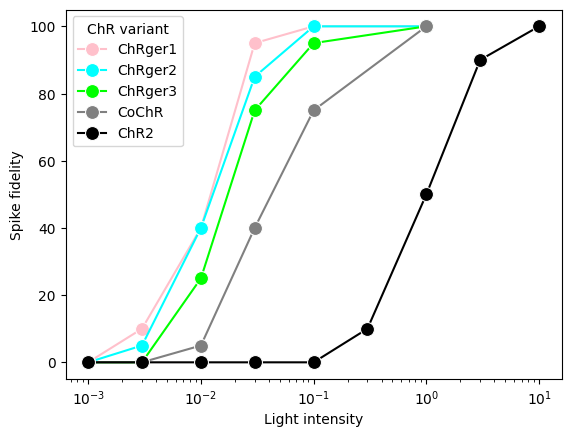

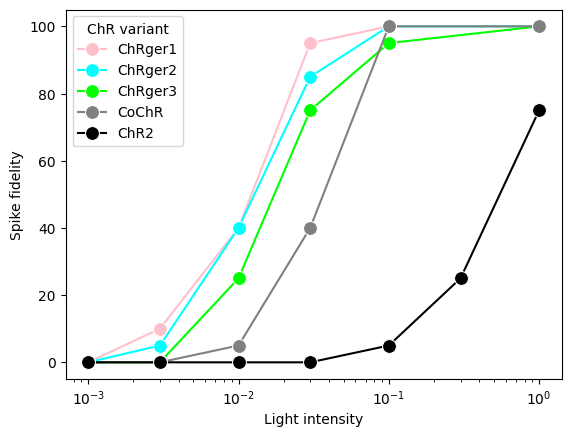

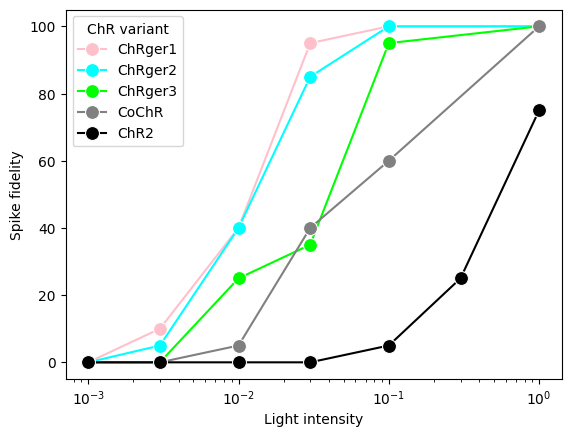

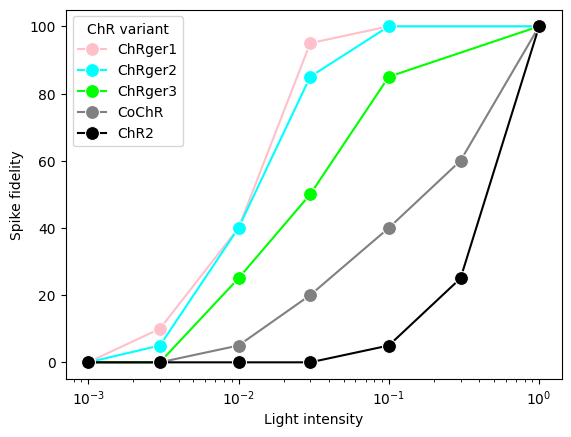

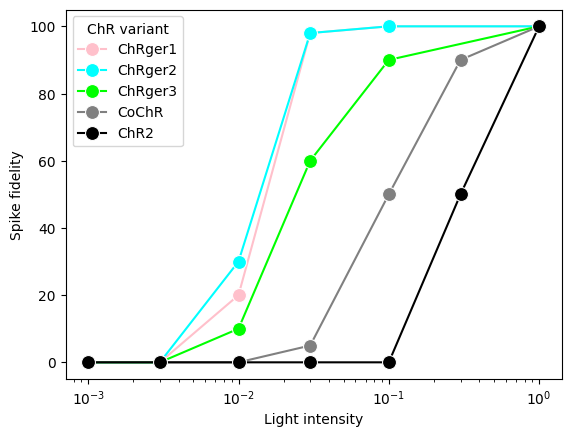

In [57]:
from matplotlib import pyplot as plt
from PIL import Image

chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
chr_variant_order = [k for k,v in chr_variant_iv.values.items()]
palette = [np.array(v)/255. for k,v in chr_variant_iv.values.items()]

fig, axes = plt.subplots()
sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    hue_order=chr_variant_order,
    markersize=10,
    palette=palette,
    ax=axes
)
axes.set_xscale('log')

# get plot as PIL Image
fig.savefig('plot_0.png')

generated_img_loop = Image.open('plot_0.png')
panel_df_loop = panel_df

for iter in range(20):




    claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620", temperature=0.5)


    prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three largest quantitative differences between the re-plotted data and the data in the source figure.
If possible, prioritize general differences that affect many datapoints over adjustments to individual datapoints.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df_loop.to_markdown()}
    """


    response__loop = claude_mm.message(prompt, images = [source_image, generated_img_loop])

    feedback_loop = response__loop.content[0].text
    print(feedback_loop)

    output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


    columns = {iv.name: pd.Series() for iv in exp.independent_variables}
    dep_var = exp.dependent_variables[0]
    columns.update({dep_var.name: pd.Series()})
    df = pd.DataFrame(columns)

    prompt_base = """
You were previously given the following task:
"In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?"

Here is you the dataframe output from your previous response:
{df_table}

We have reviewed your response and notice these important changes that will improve the match to the source figure:
{feedback}

Please revise your response by incorporating these changes. 
Adjust the values in the dataframe in the most parsimonious way possible to match the source figure.
This could mean scaling or shift all or a subset of the rows and/or columns.
Please let any specific changes inform your overall response if that is necessary to match the source figure.

And remember, our goal is to match the data points in the plot EXACTLY - not just the shapes or trends.

Return your data using the following column schema: {schema}.
    """.format(
        fig_num = fig_num,
        panel_name = panel.name, 
        # dep_var_stat = dep_var.statistics[0],
        plot_name = plot.name,
        dep_var_name = dep_var.name,
        ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
        schema = ", ".join(df.columns),
        feedback = feedback_loop,
        df_table = panel_df_loop.to_markdown(),
    ).replace("{","<").replace("}",">")

    prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    data_response_loop = query_tool(prompt)
    panel_df_loop = output_parser.parse(data_response_loop.content).to_df(existing_df=df)

    # Create a new figure and axes
    fig, axes = plt.subplots()
    
    # Plot the line plot on the new axes
    # sns.lineplot(
    #     data=panel_df_loop,
    #     x='Light intensity',
    #     y='Spike fidelity',
    #     hue='ChR variant',
    #     marker='o',
    #     # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    #     markersize=10,
    #     ax=axes
    # )
    sns.lineplot(
        data=panel_df_loop,
        x='Light intensity',
        y='Spike fidelity',
        hue='ChR variant',
        marker='o',
        hue_order=chr_variant_order,
        markersize=10,
        palette=palette,
        ax=axes
    )
    axes.set_xscale('log')

    fig.savefig(f'plot_{iter+1}.png')
    generated_img_loop = Image.open(f'plot_{iter+1}.png')

In [401]:
print(prompt)


    YOUR OVERALL JOB:
        You were previously given the following task:

            In Figure 2d, plot Spike fidelity vs Light intensity, what are the values for the dependent variable Spike fidelity?
            And you were asked to return you data in a DataFrame and were provided with information about the independent variables and their values for this plot.

        Here is you the dataframe output from your previous response:
        |    |   Light intensity | ChR variant   |   Spike fidelity |
|---:|------------------:|:--------------|-----------------:|
|  0 |             0.001 | ChRger1       |                0 |
|  1 |             0.003 | ChRger1       |                0 |
|  2 |             0.01  | ChRger1       |               10 |
|  3 |             0.03  | ChRger1       |               40 |
|  4 |             0.06  | ChRger1       |               80 |
|  5 |             0.1   | ChRger1       |               95 |
|  6 |             0.3   | ChRger1       |            

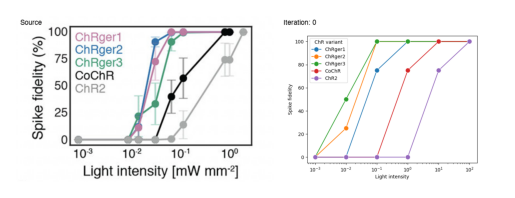

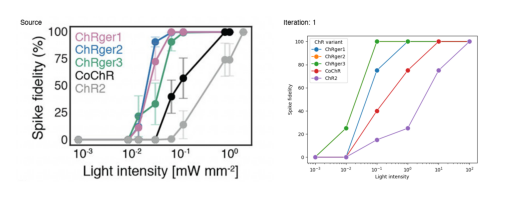

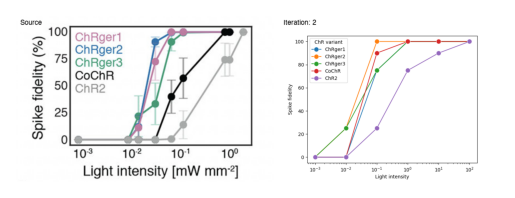

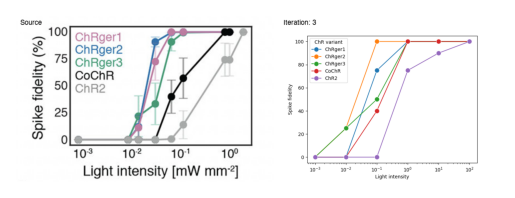

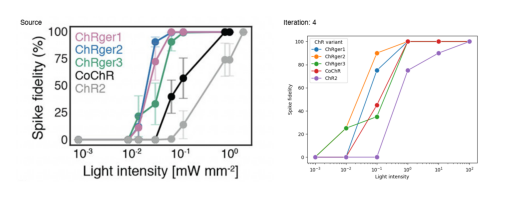

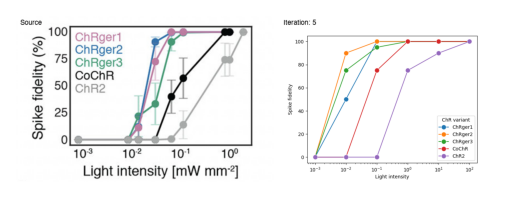

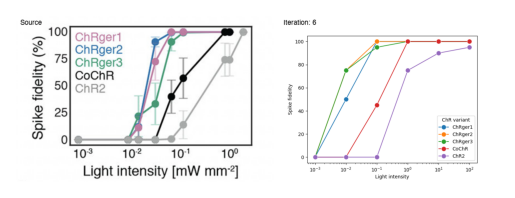

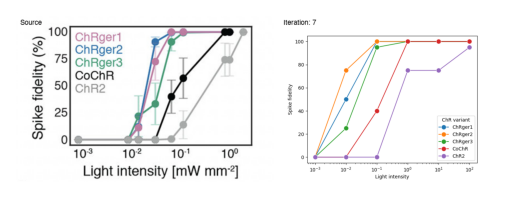

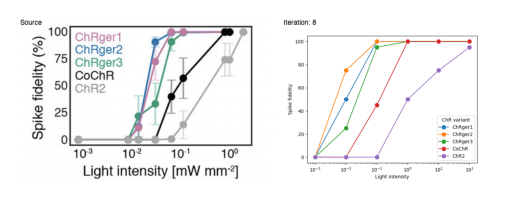

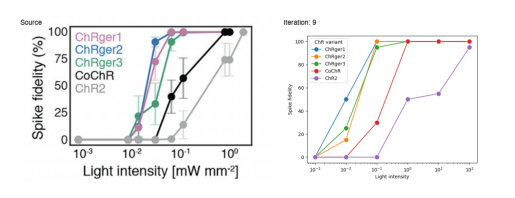

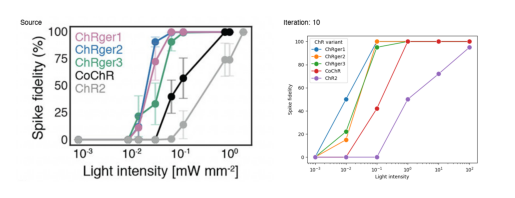

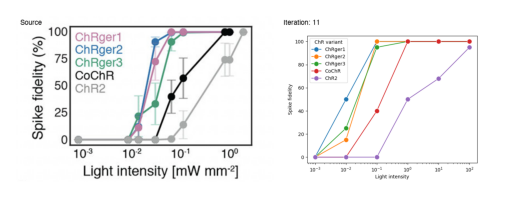

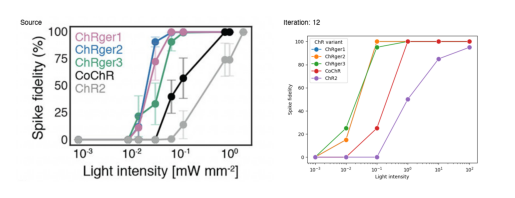

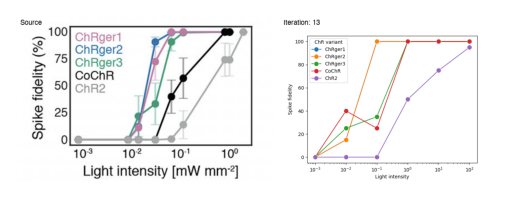

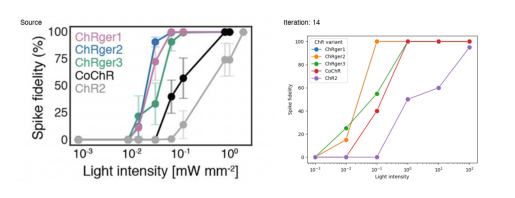

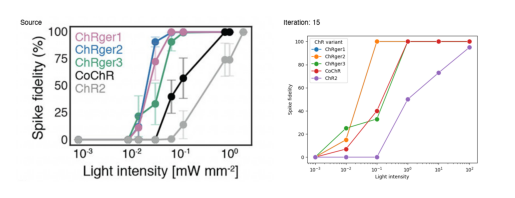

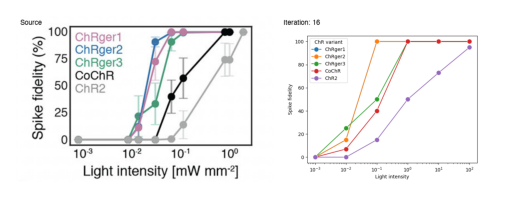

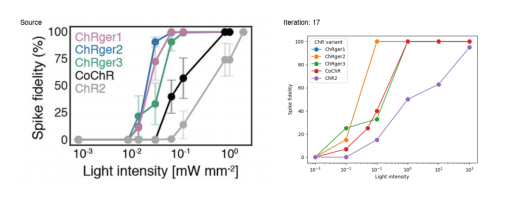

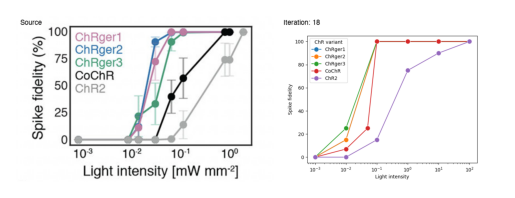

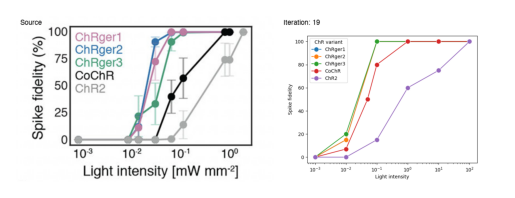

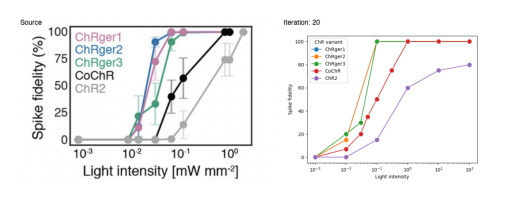

MP4 video saved as 'comparison.mp4'


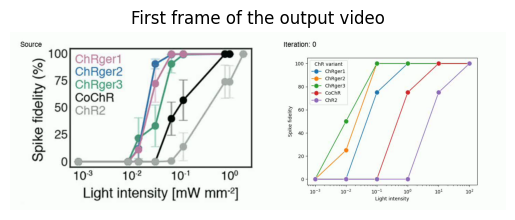

In [41]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
generated_fig_panel_path_base = "/Users/loyalshababo/dev/plotreader/sandbox/plot_{iter}.png"

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np

def create_side_by_side_image(source_img, generated_img, iter_number):
    # Resize both images to have the same height
    target_height = 480  # You can adjust this value as needed
    source_img_resized = source_img.resize((int(source_img.width * target_height / source_img.height), target_height))
    generated_img_resized = generated_img.resize((int(generated_img.width * target_height / generated_img.height), target_height))
    
    # Create a new image with the width of both resized images and the target height, plus padding
    padding = 20  # Adjust padding as needed
    total_width = source_img_resized.width + generated_img_resized.width + (3 * padding)  # Extra padding between images
    total_height = target_height + (2 * padding)
    combined_img = Image.new('RGB', (total_width, total_height), color='white')
    
    # Paste the resized source image on the left
    combined_img.paste(source_img_resized, (padding, padding))
    
    # Paste the resized generated image on the right
    combined_img.paste(generated_img_resized, (source_img_resized.width + (2 * padding), padding))
    
    # Add titles to the images
    draw = ImageDraw.Draw(combined_img)
    font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    
    # Add "Source" title
    draw.text((padding + 10, padding + 10), "Source", fill="black", font=font)
    
    # Add "Iteration: iter_number" title
    draw.text((source_img_resized.width + (2 * padding) + 10, padding + 10), f"Iteration: {iter_number}", fill="black", font=font)
    
    return combined_img

# Load the source panel image
source_img = Image.open(source_panel)

# Create a list to store the frames
frames = []

# Generate frames for each iteration
for iter in range(21):  # 0 to 10
    generated_img_path = generated_fig_panel_path_base.format(iter=iter)
    try:
        generated_img = Image.open(generated_img_path)
        
        # Create the side-by-side image with titles
        combined_img = create_side_by_side_image(source_img, generated_img, iter)
        
        # Convert PIL Image to numpy array
        frame = cv2.cvtColor(np.array(combined_img), cv2.COLOR_RGB2BGR)
        
        # Append the combined image to frames
        frames.append(frame)
    except FileNotFoundError:
        print(f"Warning: Image file not found for iteration {iter}")

# Check if we have any frames
if not frames:
    print("No frames were generated. Check if the image files exist.")
else:
    # Define the output video file
    output_file = 'comparison.mp4'

    # Get the frame size
    height, width, layers = frames[0].shape

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, 1.0, (width, height))  # 2.0 fps for 5 seconds total with 10 frames

    # Write frames to video
    for frame in frames:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        out.write(frame)

    # Release the VideoWriter
    out.release()

    print(f"MP4 video saved as '{output_file}'")

# Verify the output video
cap = cv2.VideoCapture(output_file)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("First frame of the output video")
        plt.show()
    else:
        print("Failed to read the first frame")
    cap.release()
else:
    print("Failed to open the output video file")


/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_39940/1437840151.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


[]

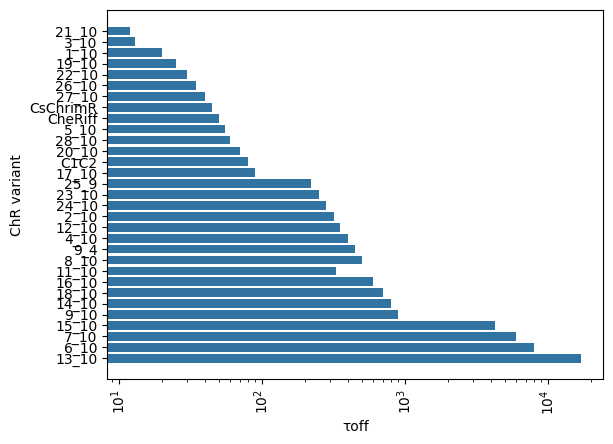

In [27]:
# panel_df_adjusted = panel_df.copy()
# panel_df_adjusted['τoff'] *= 1000

# horizontal bar plot
axes = sns.barplot(
    data=panel_df,
    x='τoff',
    y='ChR variant',
    orient='h',
)
# axes = sns.barplot(
#     data=panel_df,
#     x='ChR variant',
#     y='τoff',
# )
# rotate x-tick labels 90 deg
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.semilogx()



<Axes: xlabel='Wavelength', ylabel='Normalized photocurrent'>

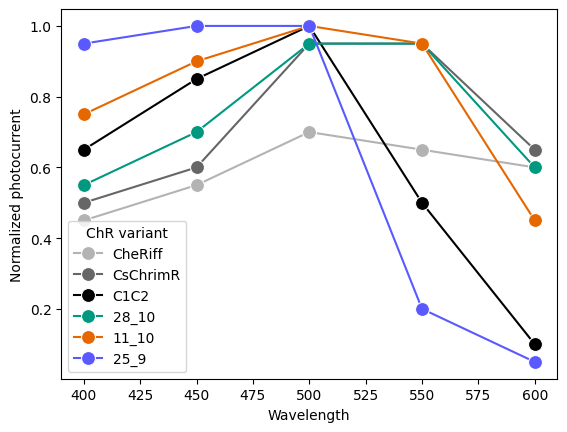

In [127]:
palette = [v for k,v in chr_variant_iv.values.items()]

sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
    palette=[[0.7, 0.7, 0.7], [0.4, 0.4, 0.4], [0, 0, 0], [0, .6 , .5], [0.9, 0.4, 0.0], [0.35, 0.35, 1.0]]
)
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [23]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [40]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import MetadataMode

In [42]:
for node in retrieverd_nodes[:-1]:
    try:
        display_source_node(node, source_length=100000)
    except:
        print(node)

**Node ID:** 7cf5ee59-0e97-445f-8884-f4e21f7bba21<br>**Similarity:** 0.40960259534169907<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents. (continued)<br>

**Node ID:** 5cb68f1f-e64c-4502-9da2-c42717a765e2<br>**Similarity:** 0.4057491962557034<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.<br>

**Node ID:** d04f54e0-29ba-4046-92a6-7d2c6e9268f0<br>**Similarity:** 0.3793601396922902<br>**Text:** Figure 2 shows that the model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.

Section a shows representative current traces after 0.5 s light exposure for select designer ChR variants with corresponding expression and localization in HEK cells. Vertical scale bar for each ChR current trace represents 1 nA, and horizontal scale bar represents 250 ms. The variant color presented in (a) is constant throughout panels. CheRiff, C1C2 are represented in gray, CsChrimR in black, 11_10 in cyan, 12_10 in magenta, 25_9 in light blue, 10_10 in yellow, 15_10 in blue, 28_10 in orange, 21_10 in purple, and 3_10 in red. The bottom row shows fluorescence images of ChR expression in HEK cells, with a 20 μm scale bar.

Section b displays measured peak and steady-state photocurrent with different wavelengths of light in HEK cells (n=4-8 cells, see Dataset 2). Four wavelengths are shown: 397 nm, 481 nm, 546 nm, and 640 nm. The y-axis shows photocurrent in pA, with different scales for each wavelength. Peak currents are represented by dark gray bars, while steady-state currents are in light gray. Error bars are included.

Section c shows off-kinetics decay rate (τoff) following a 1 ms exposure to 481 nm light at 2.3 mW mm^2 (n=4-8 cells, see Dataset 2). Parent ChRs are highlighted in light gray. The x-axis shows τoff values on a logarithmic scale from 10^1 to 10^4 ms. Inset shows representative current traces with 1 ms light exposure for select ChRs revealing distinct profiles: ChR_21_10 (purple) turns off rapidly, ChR_3_10 (red) and ChR_25_9 (light blue) turn off more slowly, and ChR_15_10 (blue) exhibits little decrease in photocurrent 0.5 s after the light exposure. The time scale for these traces is 100 ms.

Section d shows normalized photocurrent as a function of wavelength for various ChR variants. The wavelengths range from 400 nm to 600 nm. Different colored lines represent different ChR variants, corresponding to the colors in panel a.

Section e displays peak photocurrent (left) and steady-state photocurrent (right) as a function of light intensity for various ChR variants. The x-axis shows light intensity from 10^-1 to 10^1 mW mm^-2 on a logarithmic scale. The y-axis shows photocurrent in pA, up to 2500 pA. Different colored lines represent different ChR variants, corresponding to the colors in panel a. Error bars are included.<br>**Image:**

**Node ID:** 22d9ee84-5d29-4f92-8527-e0ae97939355<br>**Similarity:** 0.36910398090655805<br>**Text:** Selection of designer ChRs using trained models<br>

**Node ID:** 5bbfd688-9a2b-439b-a86b-c786e9c193e7<br>**Similarity:** 0.35990217183769474<br>**Text:** Light delivery and imaging<br>

In [47]:
index_node = node.node

In [49]:
index_node.

'Light delivery and imaging'